In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import gym

%matplotlib inline

In [2]:
with open('./ant_train_test.pkl', 'rb') as inf:
    X_tv, y_tv, X_test, y_test = pickle.load(inf)
print(X_tv.shape, X_test.shape, y_tv.shape, y_test.shape)

(16008, 111) (4002, 111) (16008, 8) (4002, 8)


In [3]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

### Build a network

* observation is an 11-dim array
* action is a (1, 3) shaped array

In [4]:
# None: batch size could vary
x_plh = tf.placeholder(tf.float32, shape=[None, X_tv.shape[1]])
y_plh = tf.placeholder(tf.float32, shape=[None, y_tv.shape[1]])

In [5]:
hidden_lay_size = 15
Wh_var = weight_variable([x_plh.shape.dims[1].value, hidden_lay_size])
bh_var = bias_variable([hidden_lay_size])
# hh = tf.nn.relu(tf.matmul(x_plh, Wh_var) + bh_var)
hh = tf.nn.sigmoid(tf.matmul(x_plh, Wh_var) + bh_var)

In [6]:
W_var = weight_variable([hidden_lay_size, y_plh.shape.dims[1].value])
b_var = bias_variable([y_plh.shape.dims[1].value])

In [7]:
y_pred = tf.matmul(hh, W_var) + b_var

In [8]:
with tf.name_scope('mse'):
    mse = tf.losses.mean_squared_error(labels=y_plh, predictions=y_pred)
    mse = tf.cast(mse, tf.float32)

In [9]:
with tf.name_scope('adam_optimizer'):
    train_op = tf.train.AdamOptimizer(1e-4).minimize(mse)

In [10]:
sess = tf.InteractiveSession()

In [11]:
sess.run(tf.global_variables_initializer())

In [12]:
mse_tv, mse_test = [], []

bs = 128      # batch size
for k in range(10): # num. epochs
    print(k, end=',')
    for i in range(X_tv.shape[0] // bs):
        _x = X_tv[i * bs : (i+1) * bs, :]
        _y = y_tv[i * bs : (i+1) * bs, :]
        train_op.run(feed_dict={x_plh: _x, y_plh: _y})

        mse_tv.append(mse.eval(feed_dict={x_plh: X_tv, y_plh: y_tv}))
        mse_test.append(mse.eval(feed_dict={x_plh: X_test, y_plh: y_test}))

0,1,2,3,4,5,6,7,8,9,

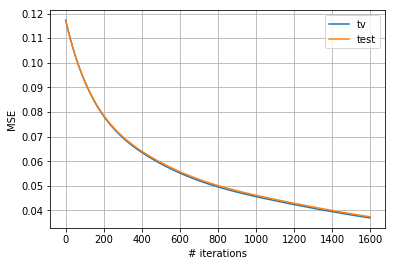

In [13]:
plt.plot(mse_tv, label='tv')
plt.plot(mse_test, label='test')
plt.legend()
plt.xlabel('# iterations')
plt.ylabel('MSE')
plt.grid()

In [15]:
print(mse_tv[-1], mse_test[-1])

0.0369854 0.0374531


**Important**: Compared to initializing weights and bias to 0, result: "0.691441 0.670476"
It demonstrates how crucial it is to initialize weights properly.

Also, compared to linear multinomial logisitic regression, non-linear 2-layer fc NN beats its performance by nearly one order of magnitude.

# Visualize performance

In [18]:
def pred_action(obs):
    return y_pred.eval(feed_dict={x_plh: obs.reshape(1, -1)})

env = gym.make('Ant-v1')

obs = env.reset()
totalr = 0
done = False
max_timesteps = 600
for k in range(max_timesteps):
    if (k + 1) % 20 == 0:
        print(k + 1, end=',')
    action = pred_action(obs[None,:])
    obs, r, done, _ = env.step(action)
    totalr += r
    env.render()
env.render(close=True)
print()
print(totalr)
print(np.mean(totalr))

20,40,60,80,100,120,140,160,180,200,220,240,260,280,300,320,340,360,380,400,420,440,460,480,500,520,540,560,580,600,
544.894740768
544.894740768


1. The visualization shows that the hopper starts well, then struggle, and then falls evetually.
1. An interesting observation is that compared to this simple network, the multinomial regression (linear) model's behavior is respectable, too. This simple NN doesn't seem to have a big edge, yet. The linear model behaves even more stably (smaller variance) than NN during multiple rollouts

#### Expert performance

Expert's return at 600 timestep is around 2878.66413703.

Collected by running `python run_expert.py experts/Ant-v1.pkl Ant-v1 --max_timesteps 600 --num_rollouts 3 --render`